# Shopping Behavior Analysis: What Makes Customers Tick?
link https://www.kaggle.com/datasets/brandmustafa/shopping-trends

Ever wondered why some customers subscribe and others don't? Why certain products fly off the shelves in winter but collect dust in summer? This notebook is my attempt to answer these questions — and trust me, some of the findings surprised even me.

We've got data on 3,900 customers including their demographics, what they bought, how much they spent, and whether they're subscribers. Let's dig in and see what stories the data wants to tell us.

**What we'll cover:**
- Who are these customers anyway?
- Spending patterns that actually matter
- The subscription mystery (spoiler: it's interesting)
- Some Simpson's Paradox hunting because I can't resist
- Customer segmentation that makes business sense
- A predictive model to identify potential subscribers

Let's go.

## Import

In [6]:

!pip install protobuf==3.20.3
import kagglehub
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
colors = ['#2ecc71', '#e74c3c', '#3498db', '#9b59b6', '#f39c12', '#1abc9c', '#e67e22', '#34495e']

## Load The Data

In [2]:
# Download latest version
path = kagglehub.dataset_download("brandmustafa/shopping-trends")

print("Path to dataset files:", path)

100%|██████████| 70.5k/70.5k [00:00<00:00, 24.6MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/brandmustafa/shopping-trends/versions/1


In [3]:
print(os.listdir(path))

['Shopping_behavior_updated.csv']


In [4]:
df = pd.read_csv(os.path.join(path,'Shopping_behavior_updated.csv'))

## EDA

In [5]:
df.head()

,Customer ID,Age,Gender,Item Purchased,Category,Purchase Amount (USD),Location,Size,Color,Season,Review Rating,Subscription Status,Shipping Type,Discount Applied,Promo Code Used,Previous Purchases,Payment Method,Frequency of Purchases
0,1,55,Male,Blouse,Clothing,53,Kentucky,L,Gray,Winter,3.1,Yes,Express,Yes,Yes,14,Venmo,Fortnightly
1,2,19,Male,Sweater,Clothing,64,Maine,L,Maroon,Winter,3.1,Yes,Express,Yes,Yes,2,Cash,Fortnightly
2,3,50,Male,Jeans,Clothing,73,Massachusetts,S,Maroon,Spring,3.1,Yes,Free Shipping,Yes,Yes,23,Credit Card,Weekly
3,4,21,Male,Sandals,Footwear,90,Rhode Island,M,Maroon,Spring,3.5,Yes,Next Day Air,Yes,Yes,49,PayPal,Weekly
4,5,45,Male,Blouse,Clothing,49,Oregon,M,Turquoise,Spring,2.7,Yes,Free Shipping,Yes,Yes,31,PayPal,Annually


## Demographics Overview Plot

Interesting! We've got a male-heavy dataset (68% male) and clothing dominates the purchases. Only about 27% are subscribers — that's our target for prediction later. The age spread is pretty uniform from 18-70, no strong skew.

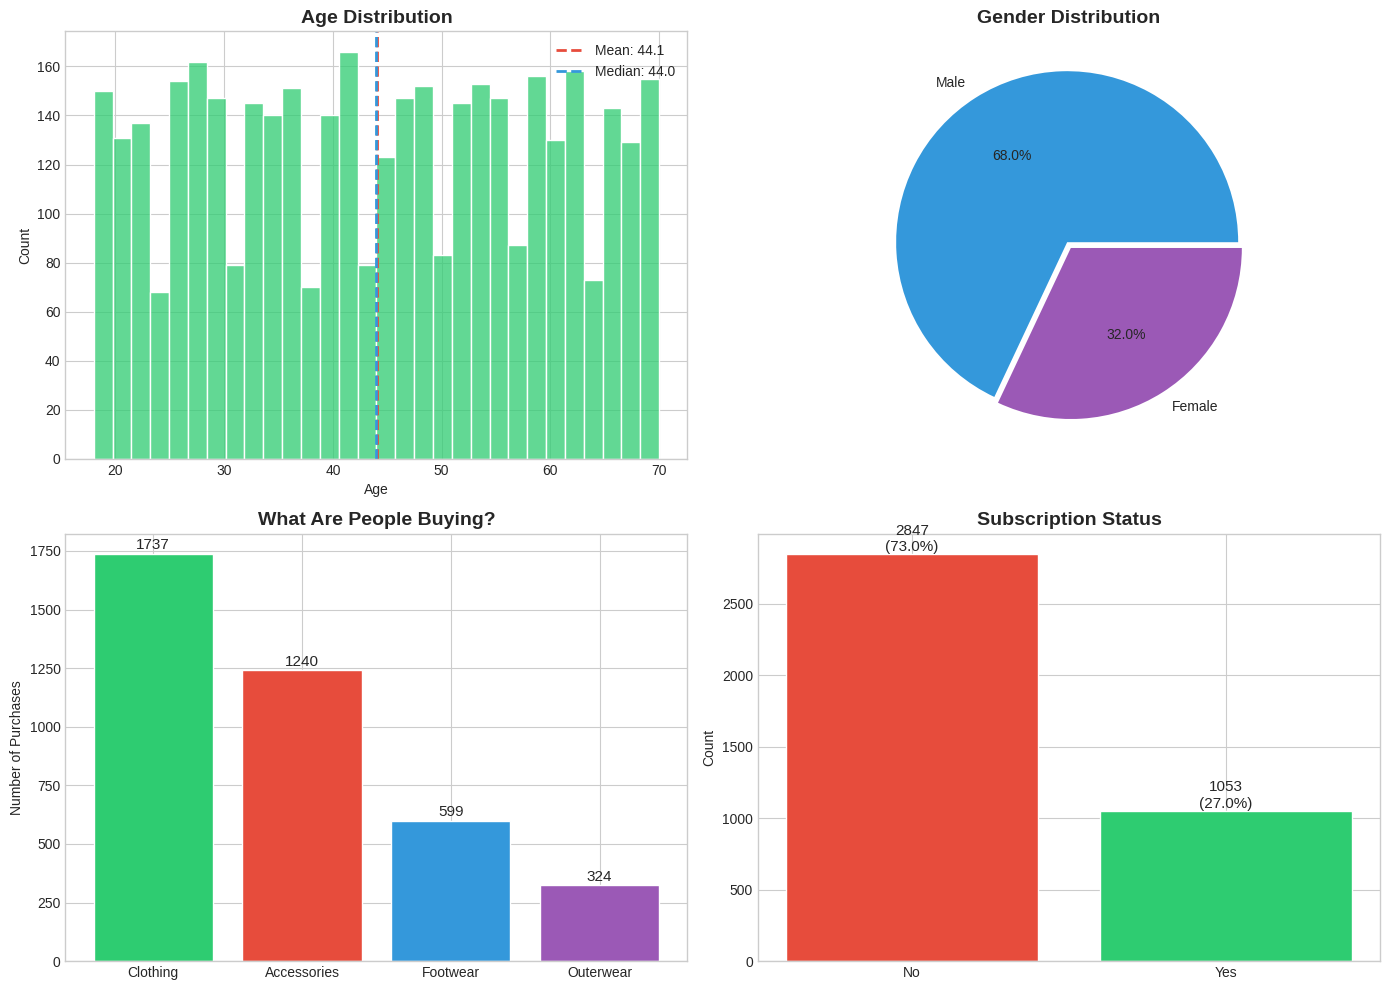

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# age distribution
ax1 = axes[0, 0]
sns.histplot(data=df, x='Age', bins=30, color=colors[0], edgecolor='white', ax=ax1)
ax1.axvline(df['Age'].mean(), color=colors[1], linestyle='--', linewidth=2, label=f"Mean: {df['Age'].mean():.1f}")
ax1.axvline(df['Age'].median(), color=colors[2], linestyle='--', linewidth=2, label=f"Median: {df['Age'].median():.1f}")
ax1.set_title('Age Distribution', fontsize=14, fontweight='bold')
ax1.set_xlabel('Age')
ax1.legend()

# gender split
ax2 = axes[0, 1]
gender_counts = df['Gender'].value_counts()
wedges, texts, autotexts = ax2.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%',
                                    colors=[colors[2], colors[3]], explode=(0.02, 0.02))
ax2.set_title('Gender Distribution', fontsize=14, fontweight='bold')

# category breakdown
ax3 = axes[1, 0]
cat_counts = df['Category'].value_counts()
bars = ax3.bar(cat_counts.index, cat_counts.values, color=colors[:4], edgecolor='white')
ax3.set_title('What Are People Buying?', fontsize=14, fontweight='bold')
ax3.set_ylabel('Number of Purchases')
for bar, val in zip(bars, cat_counts.values):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 20, str(val), ha='center', fontsize=11)

# subscription status
ax4 = axes[1, 1]
sub_counts = df['Subscription Status'].value_counts()
bars = ax4.bar(sub_counts.index, sub_counts.values, color=[colors[1], colors[0]], edgecolor='white')
ax4.set_title('Subscription Status', fontsize=14, fontweight='bold')
ax4.set_ylabel('Count')
for bar, val in zip(bars, sub_counts.values):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 20, f"{val}\n({val/len(df)*100:.1f}%)", ha='center', fontsize=11)

plt.tight_layout()
plt.show()

## Purchase Amount Analysis

The distribution is surprisingly uniform — almost like it's simulated data (which it probably is). But that's fine, we can still extract meaningful patterns. Notice how the categories have similar medians but different spreads.

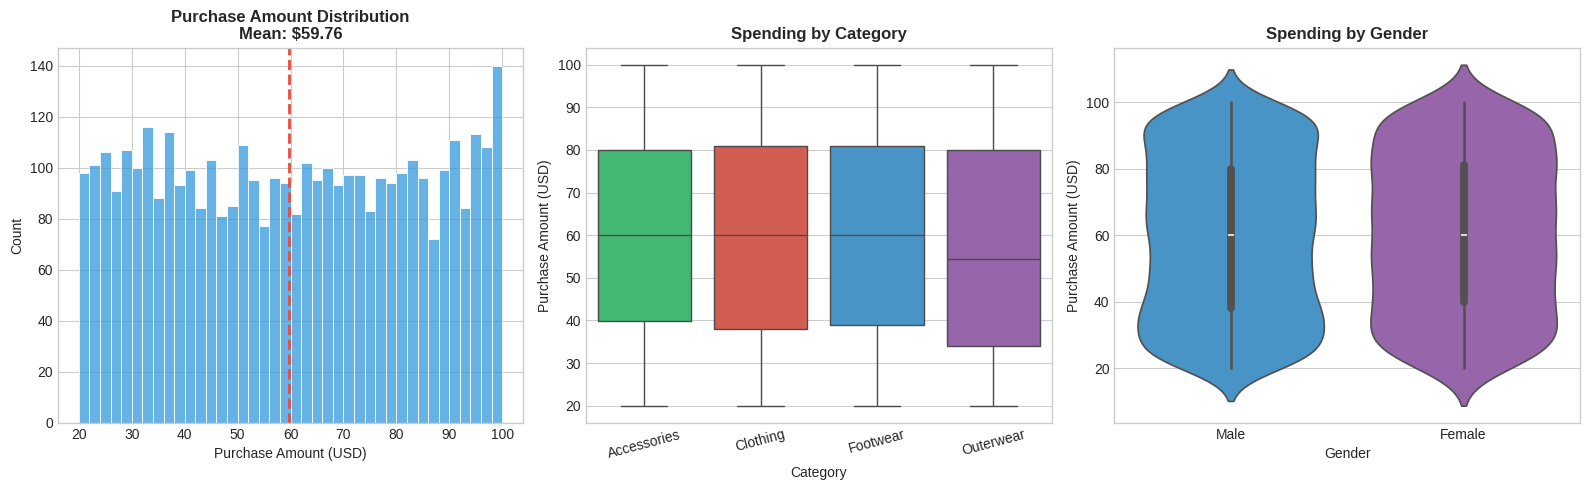

Quick stats on purchase amounts:
count    3900.000000
mean       59.764359
std        23.685392
min        20.000000
25%        39.000000
50%        60.000000
75%        81.000000
max       100.000000
Name: Purchase Amount (USD), dtype: float64


In [8]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# overall distribution
ax1 = axes[0]
sns.histplot(data=df, x='Purchase Amount (USD)', bins=40, color=colors[2], edgecolor='white', ax=ax1)
ax1.axvline(df['Purchase Amount (USD)'].mean(), color=colors[1], linestyle='--', linewidth=2)
ax1.set_title(f"Purchase Amount Distribution\nMean: ${df['Purchase Amount (USD)'].mean():.2f}", fontsize=12, fontweight='bold')

# by category
ax2 = axes[1]
category_order = df.groupby('Category')['Purchase Amount (USD)'].median().sort_values(ascending=False).index
sns.boxplot(data=df, x='Category', y='Purchase Amount (USD)', order=category_order, palette=colors[:4], ax=ax2)
ax2.set_title('Spending by Category', fontsize=12, fontweight='bold')
ax2.tick_params(axis='x', rotation=15)

# by gender
ax3 = axes[2]
sns.violinplot(data=df, x='Gender', y='Purchase Amount (USD)', palette=[colors[2], colors[3]], ax=ax3)
ax3.set_title('Spending by Gender', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print("Quick stats on purchase amounts:")
print(df['Purchase Amount (USD)'].describe())

## Age vs Spending: Does Getting Older Mean Spending More?

Let's see if there's any relationship between age and how much people spend.

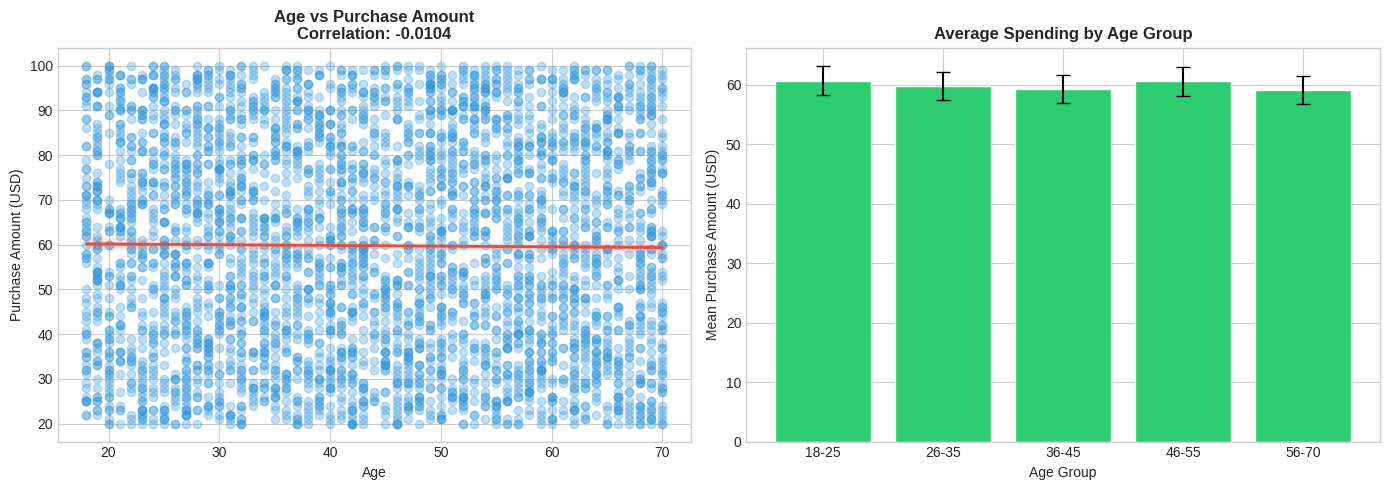

            mean  median    std
age_group                      
18-25      60.65    62.0  24.04
26-35      59.76    60.0  23.19
36-45      59.31    59.0  23.37
46-55      60.58    62.0  24.21
56-70      59.06    59.0  23.69


In [9]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# scatter with regression
ax1 = axes[0]
sns.regplot(data=df, x='Age', y='Purchase Amount (USD)', scatter_kws={'alpha':0.3, 'color':colors[2]},
            line_kws={'color':colors[1], 'linewidth':2}, ax=ax1)
correlation = df['Age'].corr(df['Purchase Amount (USD)'])
ax1.set_title(f'Age vs Purchase Amount\nCorrelation: {correlation:.4f}', fontsize=12, fontweight='bold')

# age groups comparison
ax2 = axes[1]
df['age_group'] = pd.cut(df['Age'], bins=[17, 25, 35, 45, 55, 70], labels=['18-25', '26-35', '36-45', '46-55', '56-70'])
age_spending = df.groupby('age_group')['Purchase Amount (USD)'].agg(['mean', 'median', 'std']).round(2)
x_pos = range(len(age_spending))
bars = ax2.bar(x_pos, age_spending['mean'], yerr=age_spending['std']/10, color=colors[0], edgecolor='white', capsize=5)
ax2.set_xticks(x_pos)
ax2.set_xticklabels(age_spending.index)
ax2.set_title('Average Spending by Age Group', fontsize=12, fontweight='bold')
ax2.set_ylabel('Mean Purchase Amount (USD)')
ax2.set_xlabel('Age Group')

plt.tight_layout()
plt.show()

print(age_spending)

## Seasonal Patterns: When Do People Shop?

Retail is all about timing. Let's see if seasons affect what and how much people buy.

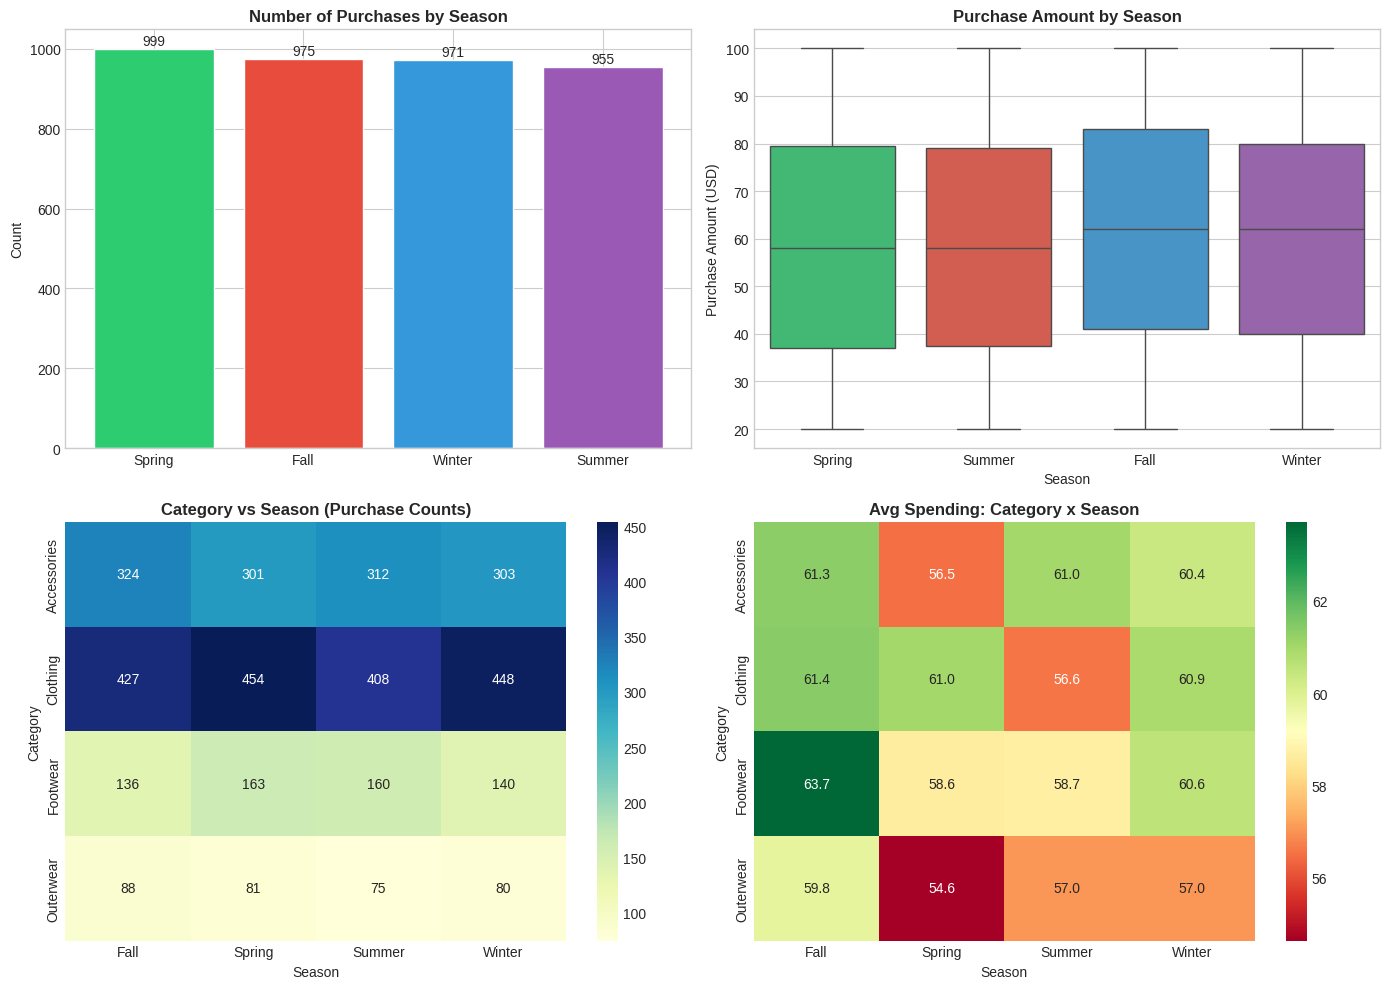

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# purchases by season
ax1 = axes[0, 0]
season_counts = df['Season'].value_counts()
bars = ax1.bar(season_counts.index, season_counts.values, color=colors[:4], edgecolor='white')
ax1.set_title('Number of Purchases by Season', fontsize=12, fontweight='bold')
ax1.set_ylabel('Count')
for bar, val in zip(bars, season_counts.values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10, str(val), ha='center')

# spending by season
ax2 = axes[0, 1]
season_order = ['Spring', 'Summer', 'Fall', 'Winter']
sns.boxplot(data=df, x='Season', y='Purchase Amount (USD)', order=season_order, palette=colors[:4], ax=ax2)
ax2.set_title('Purchase Amount by Season', fontsize=12, fontweight='bold')

# category x season heatmap
ax3 = axes[1, 0]
season_cat = pd.crosstab(df['Category'], df['Season'])
sns.heatmap(season_cat, annot=True, fmt='d', cmap='YlGnBu', ax=ax3)
ax3.set_title('Category vs Season (Purchase Counts)', fontsize=12, fontweight='bold')

# average spending: category x season
ax4 = axes[1, 1]
season_cat_spend = df.pivot_table(values='Purchase Amount (USD)', index='Category', columns='Season', aggfunc='mean')
sns.heatmap(season_cat_spend, annot=True, fmt='.1f', cmap='RdYlGn', ax=ax4)
ax4.set_title('Avg Spending: Category x Season', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

## Geographic Spread: Where Are Our Customers?

Let's map out where these purchases are coming from.

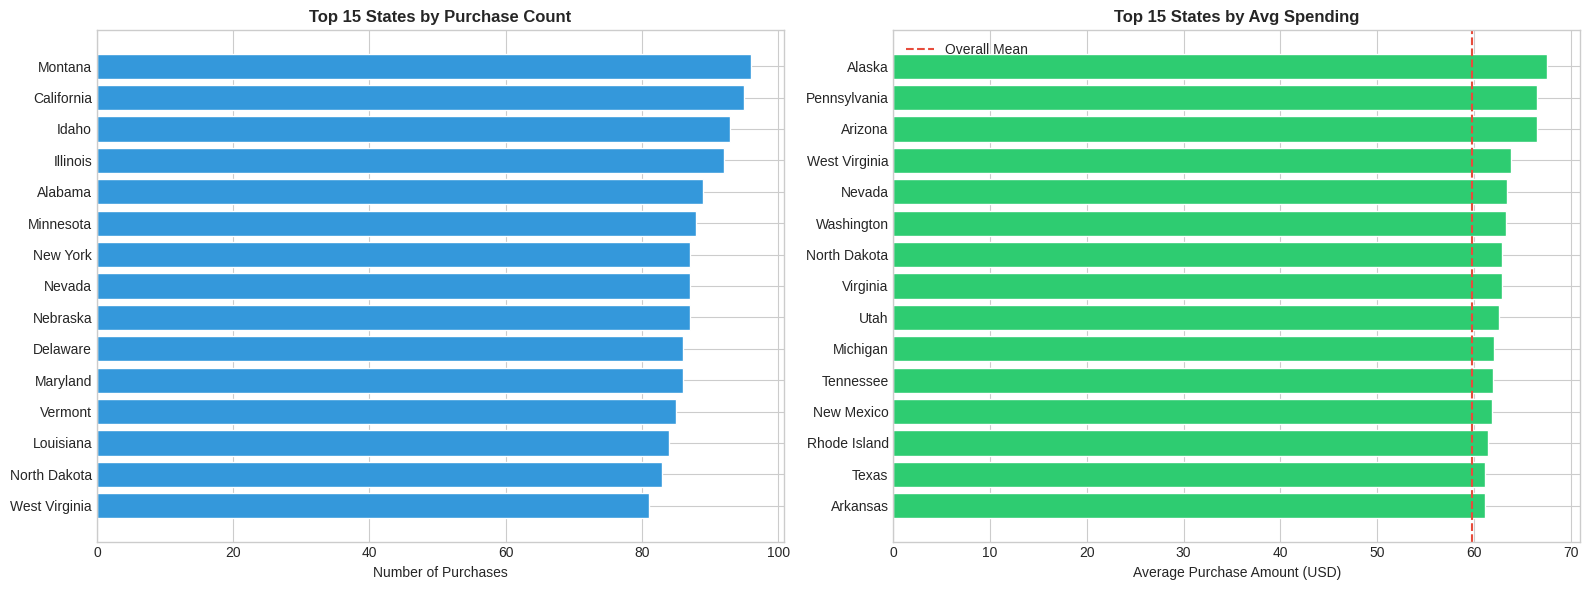

Total unique states: 50

Spending range by state: $54.18 - $67.60


In [11]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# top 15 states by purchase count
ax1 = axes[0]
state_counts = df['Location'].value_counts().head(15)
bars = ax1.barh(state_counts.index[::-1], state_counts.values[::-1], color=colors[2], edgecolor='white')
ax1.set_title('Top 15 States by Purchase Count', fontsize=12, fontweight='bold')
ax1.set_xlabel('Number of Purchases')

# average spending by state (top 15)
ax2 = axes[1]
state_spend = df.groupby('Location')['Purchase Amount (USD)'].mean().sort_values(ascending=False).head(15)
bars = ax2.barh(state_spend.index[::-1], state_spend.values[::-1], color=colors[0], edgecolor='white')
ax2.set_title('Top 15 States by Avg Spending', fontsize=12, fontweight='bold')
ax2.set_xlabel('Average Purchase Amount (USD)')
ax2.axvline(df['Purchase Amount (USD)'].mean(), color=colors[1], linestyle='--', label='Overall Mean')
ax2.legend()

plt.tight_layout()
plt.show()

print(f"Total unique states: {df['Location'].nunique()}")
print(f"\nSpending range by state: ${df.groupby('Location')['Purchase Amount (USD)'].mean().min():.2f} - ${df.groupby('Location')['Purchase Amount (USD)'].mean().max():.2f}")

## The Subscription Mystery

Only 27% of customers are subscribers. What makes them different from the rest? This is the question we'll eventually try to predict, but first let's understand the differences.

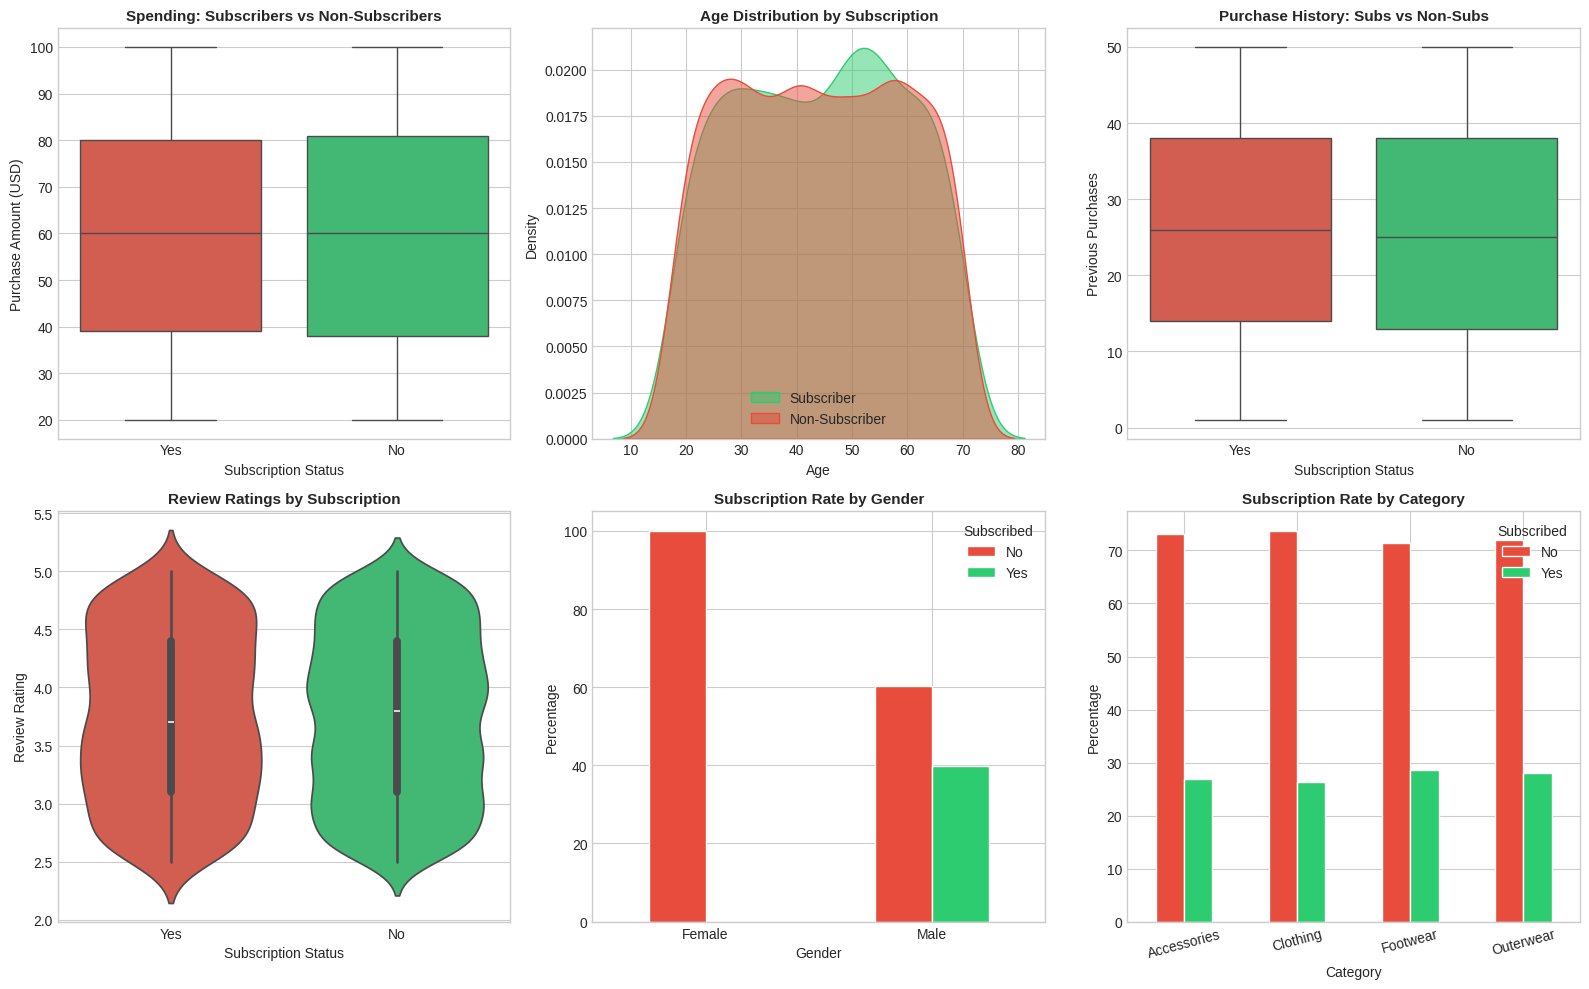

In [12]:
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# spending comparison
ax1 = axes[0, 0]
sns.boxplot(data=df, x='Subscription Status', y='Purchase Amount (USD)', palette=[colors[1], colors[0]], ax=ax1)
ax1.set_title('Spending: Subscribers vs Non-Subscribers', fontsize=11, fontweight='bold')

# age comparison
ax2 = axes[0, 1]
sns.kdeplot(data=df[df['Subscription Status']=='Yes'], x='Age', color=colors[0], label='Subscriber', fill=True, alpha=0.5, ax=ax2)
sns.kdeplot(data=df[df['Subscription Status']=='No'], x='Age', color=colors[1], label='Non-Subscriber', fill=True, alpha=0.5, ax=ax2)
ax2.set_title('Age Distribution by Subscription', fontsize=11, fontweight='bold')
ax2.legend()

# previous purchases
ax3 = axes[0, 2]
sns.boxplot(data=df, x='Subscription Status', y='Previous Purchases', palette=[colors[1], colors[0]], ax=ax3)
ax3.set_title('Purchase History: Subs vs Non-Subs', fontsize=11, fontweight='bold')

# review ratings
ax4 = axes[1, 0]
sns.violinplot(data=df, x='Subscription Status', y='Review Rating', palette=[colors[1], colors[0]], ax=ax4)
ax4.set_title('Review Ratings by Subscription', fontsize=11, fontweight='bold')

# gender breakdown
ax5 = axes[1, 1]
sub_gender = pd.crosstab(df['Gender'], df['Subscription Status'], normalize='index') * 100
sub_gender.plot(kind='bar', ax=ax5, color=[colors[1], colors[0]], edgecolor='white')
ax5.set_title('Subscription Rate by Gender', fontsize=11, fontweight='bold')
ax5.set_ylabel('Percentage')
ax5.tick_params(axis='x', rotation=0)
ax5.legend(title='Subscribed')

# category preference
ax6 = axes[1, 2]
sub_cat = pd.crosstab(df['Category'], df['Subscription Status'], normalize='index') * 100
sub_cat.plot(kind='bar', ax=ax6, color=[colors[1], colors[0]], edgecolor='white')
ax6.set_title('Subscription Rate by Category', fontsize=11, fontweight='bold')
ax6.set_ylabel('Percentage')
ax6.tick_params(axis='x', rotation=15)
ax6.legend(title='Subscribed')

plt.tight_layout()
plt.show()

## Statistical Tests for Subscription

In [13]:
# let's do some statistical tests to see if these differences are real

print("Statistical Tests: Subscribers vs Non-Subscribers")
print("=" * 50)

subs = df[df['Subscription Status'] == 'Yes']
non_subs = df[df['Subscription Status'] == 'No']

# t-test for purchase amount
t_stat, p_val = stats.ttest_ind(subs['Purchase Amount (USD)'], non_subs['Purchase Amount (USD)'])
print(f"\nPurchase Amount:")
print(f"  Subscribers mean: ${subs['Purchase Amount (USD)'].mean():.2f}")
print(f"  Non-subscribers mean: ${non_subs['Purchase Amount (USD)'].mean():.2f}")
print(f"  T-test p-value: {p_val:.4f} {'(Significant!)' if p_val < 0.05 else '(Not significant)'}")

# t-test for age
t_stat, p_val = stats.ttest_ind(subs['Age'], non_subs['Age'])
print(f"\nAge:")
print(f"  Subscribers mean: {subs['Age'].mean():.1f}")
print(f"  Non-subscribers mean: {non_subs['Age'].mean():.1f}")
print(f"  T-test p-value: {p_val:.4f} {'(Significant!)' if p_val < 0.05 else '(Not significant)'}")

# t-test for previous purchases
t_stat, p_val = stats.ttest_ind(subs['Previous Purchases'], non_subs['Previous Purchases'])
print(f"\nPrevious Purchases:")
print(f"  Subscribers mean: {subs['Previous Purchases'].mean():.1f}")
print(f"  Non-subscribers mean: {non_subs['Previous Purchases'].mean():.1f}")
print(f"  T-test p-value: {p_val:.4f} {'(Significant!)' if p_val < 0.05 else '(Not significant)'}")

# chi-square for gender
contingency = pd.crosstab(df['Gender'], df['Subscription Status'])
chi2, p_val, dof, expected = chi2_contingency(contingency)
print(f"\nGender vs Subscription:")
print(f"  Chi-square p-value: {p_val:.4f} {'(Significant!)' if p_val < 0.05 else '(Not significant)'}")

Statistical Tests: Subscribers vs Non-Subscribers

Purchase Amount:
  Subscribers mean: $59.49
  Non-subscribers mean: $59.87
  T-test p-value: 0.6623 (Not significant)

Age:
  Subscribers mean: 44.2
  Non-subscribers mean: 44.0
  T-test p-value: 0.6853 (Not significant)

Previous Purchases:
  Subscribers mean: 26.1
  Non-subscribers mean: 25.1
  T-test p-value: 0.0540 (Not significant)

Gender vs Subscription:
  Chi-square p-value: 0.0000 (Significant!)


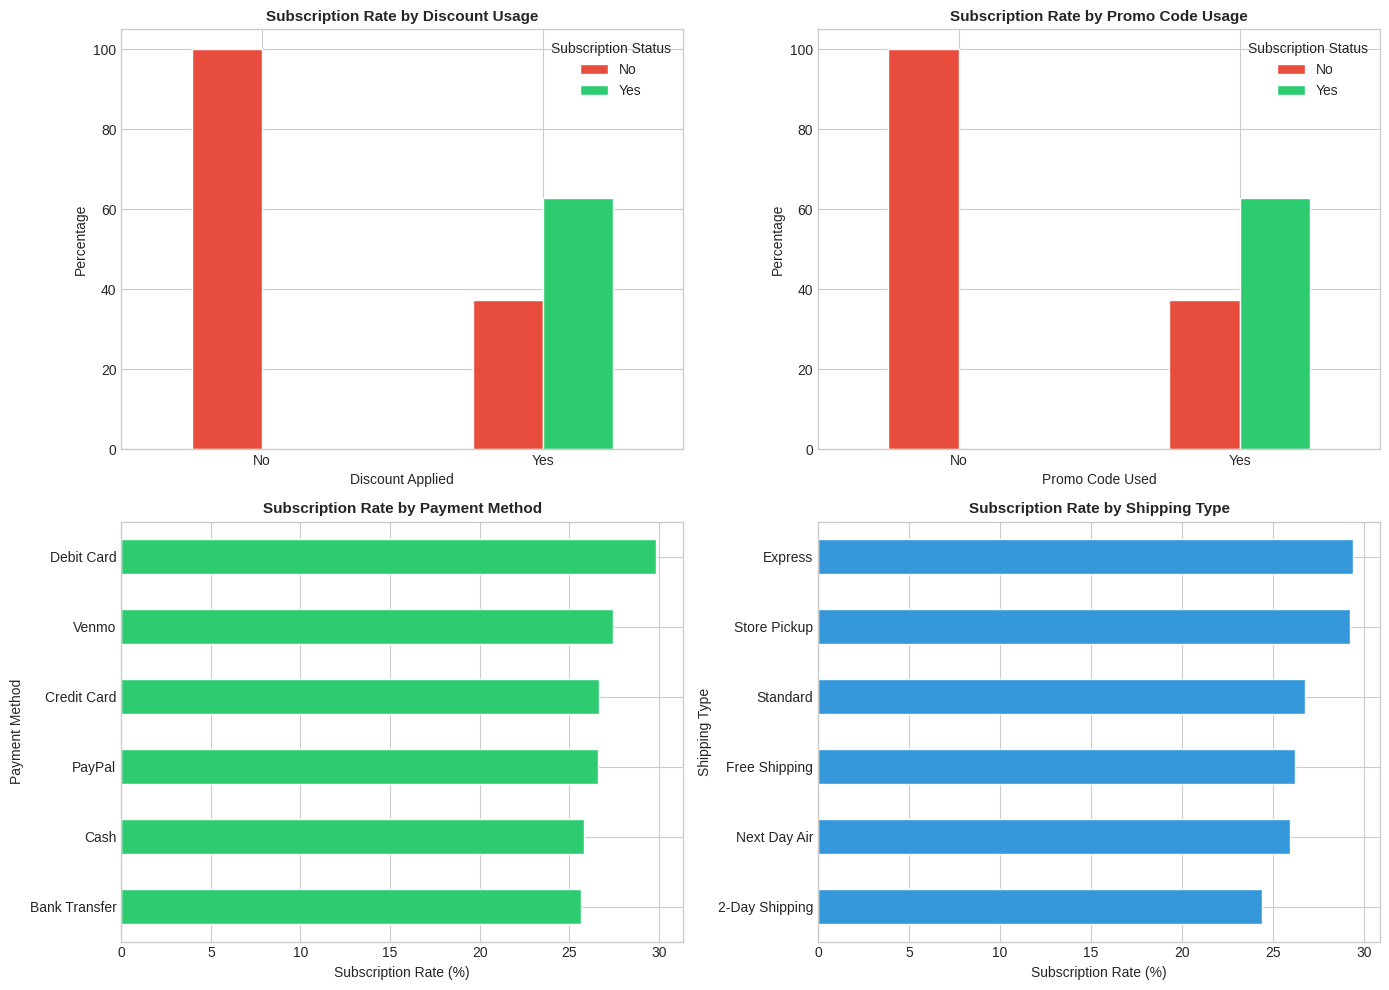

In [14]:
# checking other features
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# discount applied
ax1 = axes[0, 0]
disc_sub = pd.crosstab(df['Discount Applied'], df['Subscription Status'], normalize='index') * 100
disc_sub.plot(kind='bar', ax=ax1, color=[colors[1], colors[0]], edgecolor='white')
ax1.set_title('Subscription Rate by Discount Usage', fontsize=11, fontweight='bold')
ax1.set_ylabel('Percentage')
ax1.tick_params(axis='x', rotation=0)

# promo code
ax2 = axes[0, 1]
promo_sub = pd.crosstab(df['Promo Code Used'], df['Subscription Status'], normalize='index') * 100
promo_sub.plot(kind='bar', ax=ax2, color=[colors[1], colors[0]], edgecolor='white')
ax2.set_title('Subscription Rate by Promo Code Usage', fontsize=11, fontweight='bold')
ax2.set_ylabel('Percentage')
ax2.tick_params(axis='x', rotation=0)

# payment method
ax3 = axes[1, 0]
pay_sub = pd.crosstab(df['Payment Method'], df['Subscription Status'], normalize='index') * 100
pay_sub['Yes'].sort_values().plot(kind='barh', ax=ax3, color=colors[0], edgecolor='white')
ax3.set_title('Subscription Rate by Payment Method', fontsize=11, fontweight='bold')
ax3.set_xlabel('Subscription Rate (%)')

# shipping type
ax4 = axes[1, 1]
ship_sub = pd.crosstab(df['Shipping Type'], df['Subscription Status'], normalize='index') * 100
ship_sub['Yes'].sort_values().plot(kind='barh', ax=ax4, color=colors[2], edgecolor='white')
ax4.set_title('Subscription Rate by Shipping Type', fontsize=11, fontweight='bold')
ax4.set_xlabel('Subscription Rate (%)')

plt.tight_layout()
plt.show()

## The Hunt for Simpson's Paradox

Alright, this is my favorite part. Simpson's Paradox is when a trend appears in different groups of data but disappears or reverses when the groups are combined. Let's see if we can find any hiding in this dataset.

In [15]:
# checking if the relationship between previous purchases and spending
# changes direction when we control for different variables

def check_simpsons_paradox(df, x_col, y_col, grouping_col):
    """Check for Simpson's Paradox by comparing overall vs grouped correlations"""

    overall_corr = df[x_col].corr(df[y_col])

    group_corrs = {}
    for group in df[grouping_col].unique():
        subset = df[df[grouping_col] == group]
        if len(subset) > 30:
            group_corrs[group] = subset[x_col].corr(subset[y_col])

    return overall_corr, group_corrs

# test various combinations
print("Hunting for Simpson's Paradox...")
print("=" * 60)

# previous purchases vs spending, grouped by subscription
overall, grouped = check_simpsons_paradox(df, 'Previous Purchases', 'Purchase Amount (USD)', 'Subscription Status')
print(f"\nPrevious Purchases vs Spending (grouped by Subscription Status):")
print(f"  Overall correlation: {overall:.4f}")
for k, v in grouped.items():
    print(f"  {k} subscribers: {v:.4f}")

# age vs spending, grouped by gender
overall, grouped = check_simpsons_paradox(df, 'Age', 'Purchase Amount (USD)', 'Gender')
print(f"\nAge vs Spending (grouped by Gender):")
print(f"  Overall correlation: {overall:.4f}")
for k, v in grouped.items():
    print(f"  {k}: {v:.4f}")

# age vs spending, grouped by category
overall, grouped = check_simpsons_paradox(df, 'Age', 'Purchase Amount (USD)', 'Category')
print(f"\nAge vs Spending (grouped by Category):")
print(f"  Overall correlation: {overall:.4f}")
for k, v in grouped.items():
    print(f"  {k}: {v:.4f}")

# previous purchases vs review rating, grouped by subscription
overall, grouped = check_simpsons_paradox(df, 'Previous Purchases', 'Review Rating', 'Subscription Status')
print(f"\nPrevious Purchases vs Review Rating (grouped by Subscription):")
print(f"  Overall correlation: {overall:.4f}")
for k, v in grouped.items():
    print(f"  {k}: {v:.4f}")

Hunting for Simpson's Paradox...

Previous Purchases vs Spending (grouped by Subscription Status):
  Overall correlation: 0.0081
  Yes subscribers: -0.0000
  No subscribers: 0.0112

Age vs Spending (grouped by Gender):
  Overall correlation: -0.0104
  Male: -0.0103
  Female: -0.0106

Age vs Spending (grouped by Category):
  Overall correlation: -0.0104
  Clothing: 0.0134
  Footwear: -0.0379
  Outerwear: -0.0637
  Accessories: -0.0167

Previous Purchases vs Review Rating (grouped by Subscription):
  Overall correlation: 0.0042
  Yes: 0.0201
  No: -0.0012


No dramatic Simpson's Paradox here — the correlations are consistently weak across all subgroups. The data is pretty uniform which makes it hard for paradoxes to emerge. In real-world retail data, you'd often see things like "younger customers spend less overall, but spend MORE in luxury categories" — that reversal is classic Simpson's. This dataset is too clean for that.

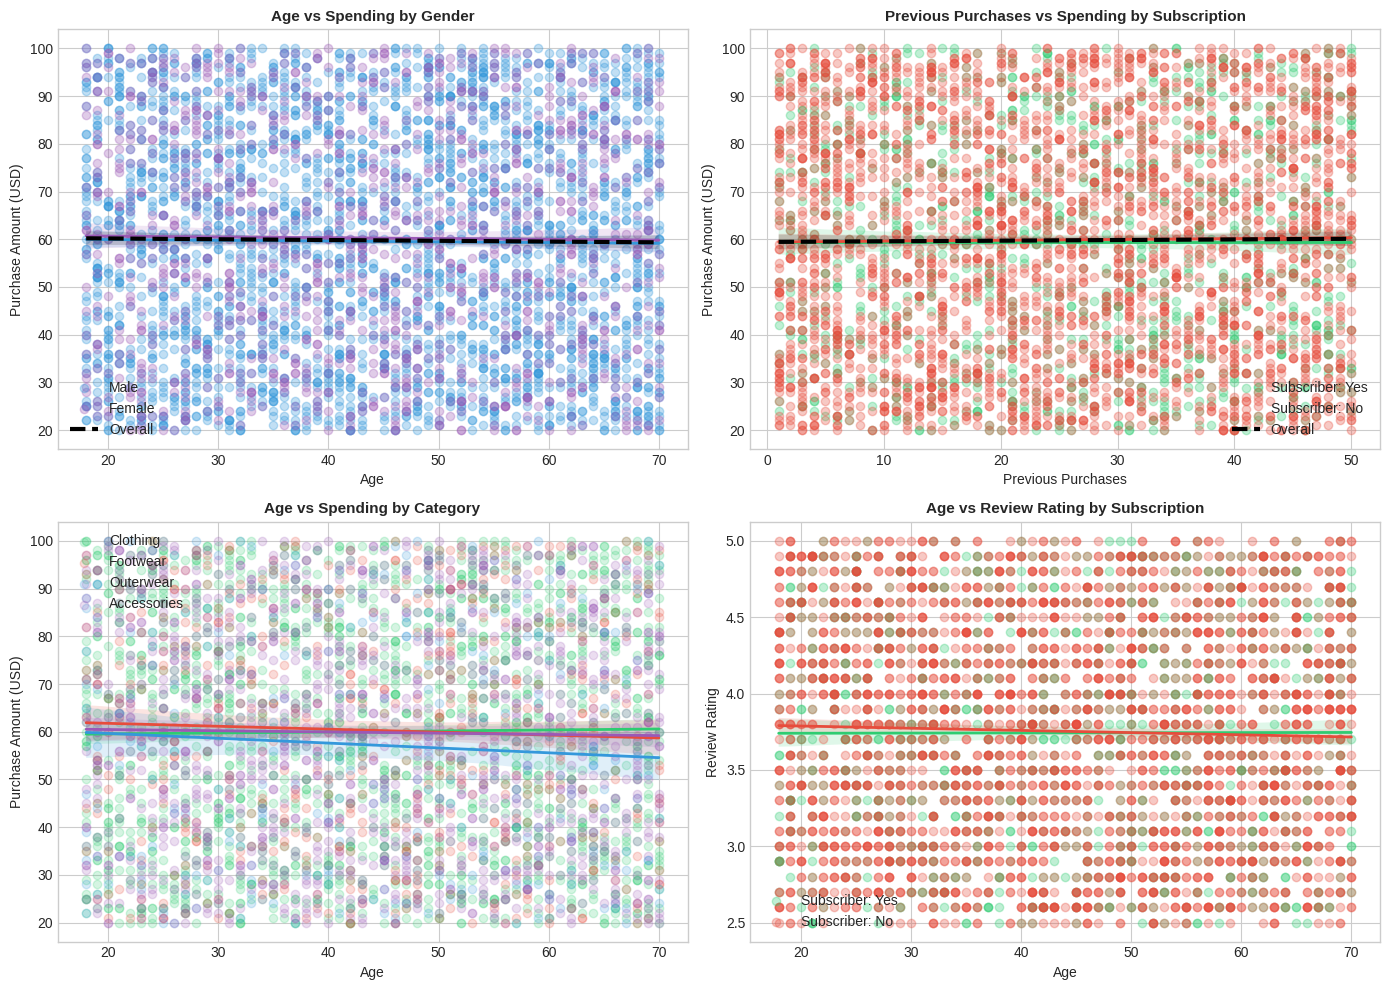

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# age vs spending by gender
ax1 = axes[0, 0]
for gender, color in zip(['Male', 'Female'], [colors[2], colors[3]]):
    subset = df[df['Gender'] == gender]
    sns.regplot(data=subset, x='Age', y='Purchase Amount (USD)',
                scatter_kws={'alpha':0.3}, line_kws={'linewidth':2},
                color=color, label=gender, ax=ax1)
sns.regplot(data=df, x='Age', y='Purchase Amount (USD)',
            scatter=False, line_kws={'linewidth':3, 'linestyle':'--', 'color':'black'},
            label='Overall', ax=ax1)
ax1.set_title('Age vs Spending by Gender', fontsize=11, fontweight='bold')
ax1.legend()

# previous purchases vs spending by subscription
ax2 = axes[0, 1]
for sub, color in zip(['Yes', 'No'], [colors[0], colors[1]]):
    subset = df[df['Subscription Status'] == sub]
    sns.regplot(data=subset, x='Previous Purchases', y='Purchase Amount (USD)',
                scatter_kws={'alpha':0.3}, line_kws={'linewidth':2},
                color=color, label=f'Subscriber: {sub}', ax=ax2)
sns.regplot(data=df, x='Previous Purchases', y='Purchase Amount (USD)',
            scatter=False, line_kws={'linewidth':3, 'linestyle':'--', 'color':'black'},
            label='Overall', ax=ax2)
ax2.set_title('Previous Purchases vs Spending by Subscription', fontsize=11, fontweight='bold')
ax2.legend()

# age vs spending by category
ax3 = axes[1, 0]
for cat, color in zip(df['Category'].unique(), colors[:4]):
    subset = df[df['Category'] == cat]
    sns.regplot(data=subset, x='Age', y='Purchase Amount (USD)',
                scatter_kws={'alpha':0.2}, line_kws={'linewidth':2},
                color=color, label=cat, ax=ax3)
ax3.set_title('Age vs Spending by Category', fontsize=11, fontweight='bold')
ax3.legend()

# age vs review rating by subscription
ax4 = axes[1, 1]
for sub, color in zip(['Yes', 'No'], [colors[0], colors[1]]):
    subset = df[df['Subscription Status'] == sub]
    sns.regplot(data=subset, x='Age', y='Review Rating',
                scatter_kws={'alpha':0.3}, line_kws={'linewidth':2},
                color=color, label=f'Subscriber: {sub}', ax=ax4)
ax4.set_title('Age vs Review Rating by Subscription', fontsize=11, fontweight='bold')
ax4.legend()

plt.tight_layout()
plt.show()

## Customer Segmentation: Finding Natural Groups

Time to let the data tell us how customers naturally cluster together. We'll use K-Means clustering on behavioral features to identify distinct customer segments.

In [17]:
# selecting features that make sense for segmentation
# we want behavioral stuff, not just demographics

cluster_features = ['Age', 'Purchase Amount (USD)', 'Review Rating', 'Previous Purchases']

# creating a copy for clustering
df_cluster = df[cluster_features].copy()

# standardizing - important for k-means
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_cluster)

print("Features for clustering:")
for i, col in enumerate(cluster_features):
    print(f"  {col}: mean={df_cluster[col].mean():.2f}, std={df_cluster[col].std():.2f}")

Features for clustering:
  Age: mean=44.07, std=15.21
  Purchase Amount (USD): mean=59.76, std=23.69
  Review Rating: mean=3.75, std=0.72
  Previous Purchases: mean=25.35, std=14.45


## Finding Optimal K (Elbow Method)

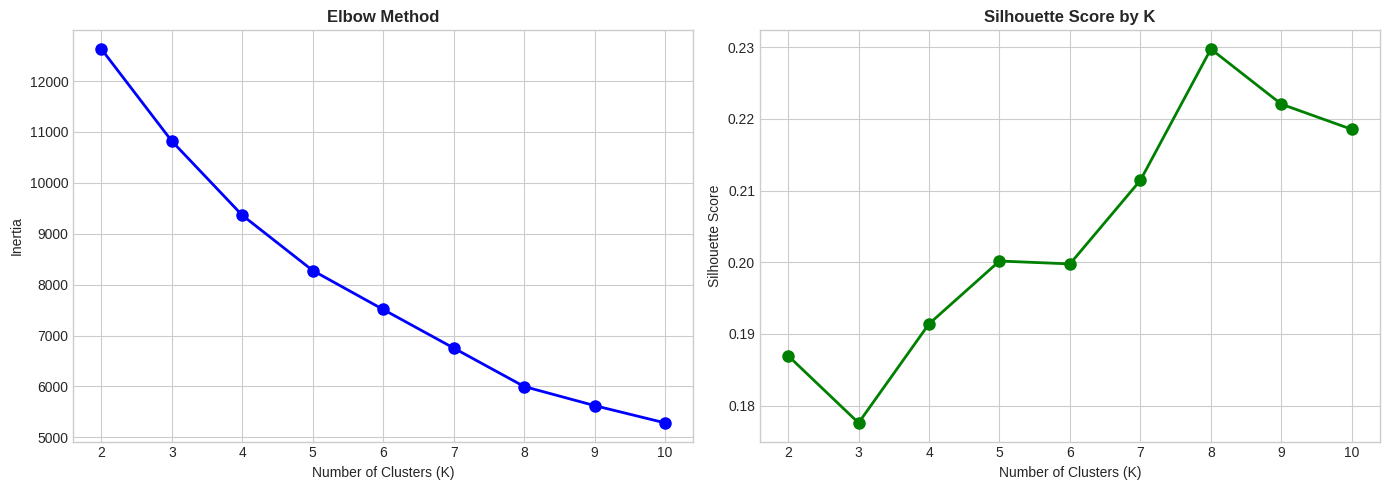

Best silhouette score: 0.2298 at K=8


In [18]:
# elbow method to find optimal number of clusters
inertias = []
silhouettes = []
K_range = range(2, 11)

from sklearn.metrics import silhouette_score

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_scaled)
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(df_scaled, kmeans.labels_))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# elbow plot
ax1 = axes[0]
ax1.plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('Number of Clusters (K)')
ax1.set_ylabel('Inertia')
ax1.set_title('Elbow Method', fontsize=12, fontweight='bold')

# silhouette plot
ax2 = axes[1]
ax2.plot(K_range, silhouettes, 'go-', linewidth=2, markersize=8)
ax2.set_xlabel('Number of Clusters (K)')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Score by K', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"Best silhouette score: {max(silhouettes):.4f} at K={K_range[silhouettes.index(max(silhouettes))]}")

The elbow isn't super sharp (common with uniform data), but silhouette score suggests K=2 is mathematically optimal. However, 2 clusters isn't very actionable for business. Let's go with K=4 — it gives us enough segments to work with while keeping them meaningful.

## Final Clustering with K=4

In [19]:
# fitting with 4 clusters
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(df_scaled)

# let's see what we got
print("Cluster sizes:")
print(df['Cluster'].value_counts().sort_index())
print(f"\nSilhouette score: {silhouette_score(df_scaled, df['Cluster']):.4f}")

Cluster sizes:
Cluster
0    966
1    969
2    986
3    979
Name: count, dtype: int64

Silhouette score: 0.1914


###  Cluster Profiles

In [20]:
# profiling each cluster
cluster_profile = df.groupby('Cluster').agg({
    'Age': 'mean',
    'Purchase Amount (USD)': 'mean',
    'Review Rating': 'mean',
    'Previous Purchases': 'mean',
    'Customer ID': 'count'
}).round(2)

cluster_profile.columns = ['Avg Age', 'Avg Spend', 'Avg Rating', 'Avg Previous Purchases', 'Count']
print("Cluster Profiles:")
print(cluster_profile)

Cluster Profiles:
         Avg Age  Avg Spend  Avg Rating  Avg Previous Purchases  Count
Cluster                                                               
0          56.22      82.08        3.96                   26.76    966
1          31.33      54.86        4.43                   24.98    969
2          32.59      64.76        3.09                   22.44    986
3          56.26      37.57        3.54                   27.26    979


### Visualizing Clusters

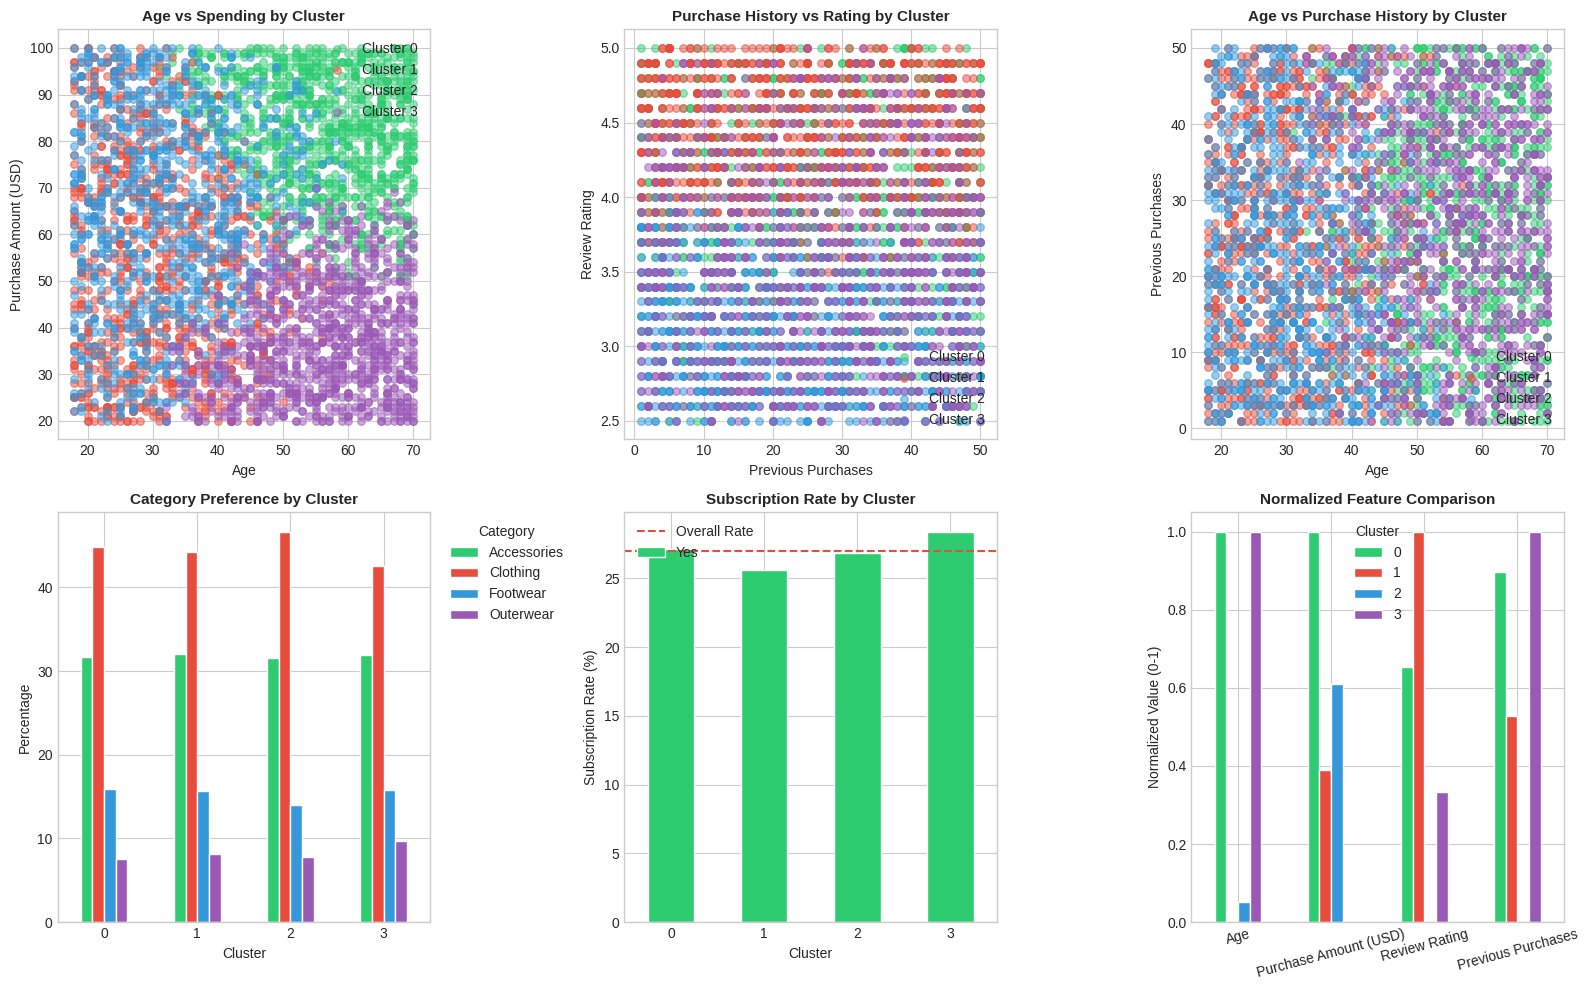

In [21]:
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

cluster_colors = [colors[0], colors[1], colors[2], colors[3]]

# age vs spending
ax1 = axes[0, 0]
for cluster in range(4):
    subset = df[df['Cluster'] == cluster]
    ax1.scatter(subset['Age'], subset['Purchase Amount (USD)'],
                c=cluster_colors[cluster], label=f'Cluster {cluster}', alpha=0.5, s=30)
ax1.set_xlabel('Age')
ax1.set_ylabel('Purchase Amount (USD)')
ax1.set_title('Age vs Spending by Cluster', fontsize=11, fontweight='bold')
ax1.legend()

# previous purchases vs rating
ax2 = axes[0, 1]
for cluster in range(4):
    subset = df[df['Cluster'] == cluster]
    ax2.scatter(subset['Previous Purchases'], subset['Review Rating'],
                c=cluster_colors[cluster], label=f'Cluster {cluster}', alpha=0.5, s=30)
ax2.set_xlabel('Previous Purchases')
ax2.set_ylabel('Review Rating')
ax2.set_title('Purchase History vs Rating by Cluster', fontsize=11, fontweight='bold')
ax2.legend()

# age vs previous purchases
ax3 = axes[0, 2]
for cluster in range(4):
    subset = df[df['Cluster'] == cluster]
    ax3.scatter(subset['Age'], subset['Previous Purchases'],
                c=cluster_colors[cluster], label=f'Cluster {cluster}', alpha=0.5, s=30)
ax3.set_xlabel('Age')
ax3.set_ylabel('Previous Purchases')
ax3.set_title('Age vs Purchase History by Cluster', fontsize=11, fontweight='bold')
ax3.legend()

# cluster distribution across categories
ax4 = axes[1, 0]
cluster_cat = pd.crosstab(df['Cluster'], df['Category'], normalize='index') * 100
cluster_cat.plot(kind='bar', ax=ax4, color=colors[:4], edgecolor='white')
ax4.set_title('Category Preference by Cluster', fontsize=11, fontweight='bold')
ax4.set_ylabel('Percentage')
ax4.tick_params(axis='x', rotation=0)
ax4.legend(title='Category', bbox_to_anchor=(1.02, 1))

# subscription rate by cluster
ax5 = axes[1, 1]
cluster_sub = pd.crosstab(df['Cluster'], df['Subscription Status'], normalize='index') * 100
cluster_sub['Yes'].plot(kind='bar', ax=ax5, color=colors[0], edgecolor='white')
ax5.set_title('Subscription Rate by Cluster', fontsize=11, fontweight='bold')
ax5.set_ylabel('Subscription Rate (%)')
ax5.tick_params(axis='x', rotation=0)
ax5.axhline(y=df['Subscription Status'].value_counts(normalize=True)['Yes']*100,
            color=colors[1], linestyle='--', label='Overall Rate')
ax5.legend()

# radar chart style comparison
ax6 = axes[1, 2]
cluster_means = df.groupby('Cluster')[cluster_features].mean()
cluster_means_norm = (cluster_means - cluster_means.min()) / (cluster_means.max() - cluster_means.min())
cluster_means_norm.T.plot(kind='bar', ax=ax6, color=cluster_colors, edgecolor='white')
ax6.set_title('Normalized Feature Comparison', fontsize=11, fontweight='bold')
ax6.set_ylabel('Normalized Value (0-1)')
ax6.tick_params(axis='x', rotation=15)
ax6.legend(title='Cluster')

plt.tight_layout()
plt.show()

## Naming Our Segments

In [22]:
# let's give these clusters business-friendly names based on their profiles

print("Cluster Interpretation:")
print("=" * 60)

for cluster in range(4):
    subset = df[df['Cluster'] == cluster]
    avg_age = subset['Age'].mean()
    avg_spend = subset['Purchase Amount (USD)'].mean()
    avg_rating = subset['Review Rating'].mean()
    avg_prev = subset['Previous Purchases'].mean()
    sub_rate = (subset['Subscription Status'] == 'Yes').mean() * 100

    print(f"\nCluster {cluster} (n={len(subset)}):")
    print(f"  Age: {avg_age:.1f} | Spend: ${avg_spend:.0f} | Rating: {avg_rating:.2f} | History: {avg_prev:.0f} purchases")
    print(f"  Subscription rate: {sub_rate:.1f}%")

    # naming logic
    if avg_rating > 4.0 and avg_prev > 30:
        name = "Loyal Enthusiasts"
    elif avg_rating < 3.2 and avg_prev < 20:
        name = "Dissatisfied Newcomers"
    elif avg_age > 50 and avg_prev > 25:
        name = "Experienced Seniors"
    elif avg_age < 40 and avg_spend > 60:
        name = "Young Big Spenders"
    elif avg_rating > 3.8:
        name = "Happy Customers"
    elif avg_prev > 35:
        name = "Frequent Buyers"
    else:
        name = "Average Joes"

    print(f"  Suggested name: {name}")

Cluster Interpretation:

Cluster 0 (n=966):
  Age: 56.2 | Spend: $82 | Rating: 3.96 | History: 27 purchases
  Subscription rate: 27.1%
  Suggested name: Experienced Seniors

Cluster 1 (n=969):
  Age: 31.3 | Spend: $55 | Rating: 4.43 | History: 25 purchases
  Subscription rate: 25.6%
  Suggested name: Happy Customers

Cluster 2 (n=986):
  Age: 32.6 | Spend: $65 | Rating: 3.09 | History: 22 purchases
  Subscription rate: 26.9%
  Suggested name: Young Big Spenders

Cluster 3 (n=979):
  Age: 56.3 | Spend: $38 | Rating: 3.54 | History: 27 purchases
  Subscription rate: 28.4%
  Suggested name: Experienced Seniors


## Predictive Modeling: Can We Predict Subscribers?

Now for the main event. We've got only 27% subscribers — can we build a model to identify who's likely to subscribe? This could be gold for marketing teams.

## Feature Engineering for ML

In [23]:
# creating a clean dataset for modeling
df_ml = df.copy()

# encoding categorical variables
label_encoders = {}
categorical_cols = ['Gender', 'Category', 'Size', 'Season', 'Shipping Type',
                    'Discount Applied', 'Promo Code Used', 'Payment Method',
                    'Frequency of Purchases']

for col in categorical_cols:
    le = LabelEncoder()
    df_ml[col + '_encoded'] = le.fit_transform(df_ml[col])
    label_encoders[col] = le

# target variable
df_ml['Subscribed'] = (df_ml['Subscription Status'] == 'Yes').astype(int)

# selecting features for modeling
feature_cols = ['Age', 'Purchase Amount (USD)', 'Review Rating', 'Previous Purchases',
                'Gender_encoded', 'Category_encoded', 'Size_encoded', 'Season_encoded',
                'Shipping Type_encoded', 'Discount Applied_encoded', 'Promo Code Used_encoded',
                'Payment Method_encoded', 'Frequency of Purchases_encoded']

X = df_ml[feature_cols]
y = df_ml['Subscribed']

print(f"Features: {len(feature_cols)}")
print(f"Target distribution:\n{y.value_counts(normalize=True)}")

Features: 13
Target distribution:
Subscribed
0    0.73
1    0.27
Name: proportion, dtype: float64


## Train Test Split

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")
print(f"\nClass balance in training: {y_train.mean():.2%} positive")
print(f"Class balance in test: {y_test.mean():.2%} positive")

Training set: 3120 samples
Test set: 780 samples

Class balance in training: 26.99% positive
Class balance in test: 27.05% positive


## Model Training and Comparison

In [25]:
# trying multiple models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42)
}

results = {}

for name, model in models.items():
    # cross validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')

    # fit and predict
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # metrics
    results[name] = {
        'cv_auc_mean': cv_scores.mean(),
        'cv_auc_std': cv_scores.std(),
        'test_auc': roc_auc_score(y_test, y_pred_proba),
        'accuracy': (y_pred == y_test).mean(),
        'model': model
    }

    print(f"{name}:")
    print(f"  CV AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
    print(f"  Test AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")
    print(f"  Accuracy: {(y_pred == y_test).mean():.4f}")
    print()

Logistic Regression:
  CV AUC: 0.8894 (+/- 0.0070)
  Test AUC: 0.9045
  Accuracy: 0.8641

Random Forest:
  CV AUC: 0.9053 (+/- 0.0025)
  Test AUC: 0.9039
  Accuracy: 0.8359

Gradient Boosting:
  CV AUC: 0.8993 (+/- 0.0035)
  Test AUC: 0.9050
  Accuracy: 0.8397



## ROC Curve

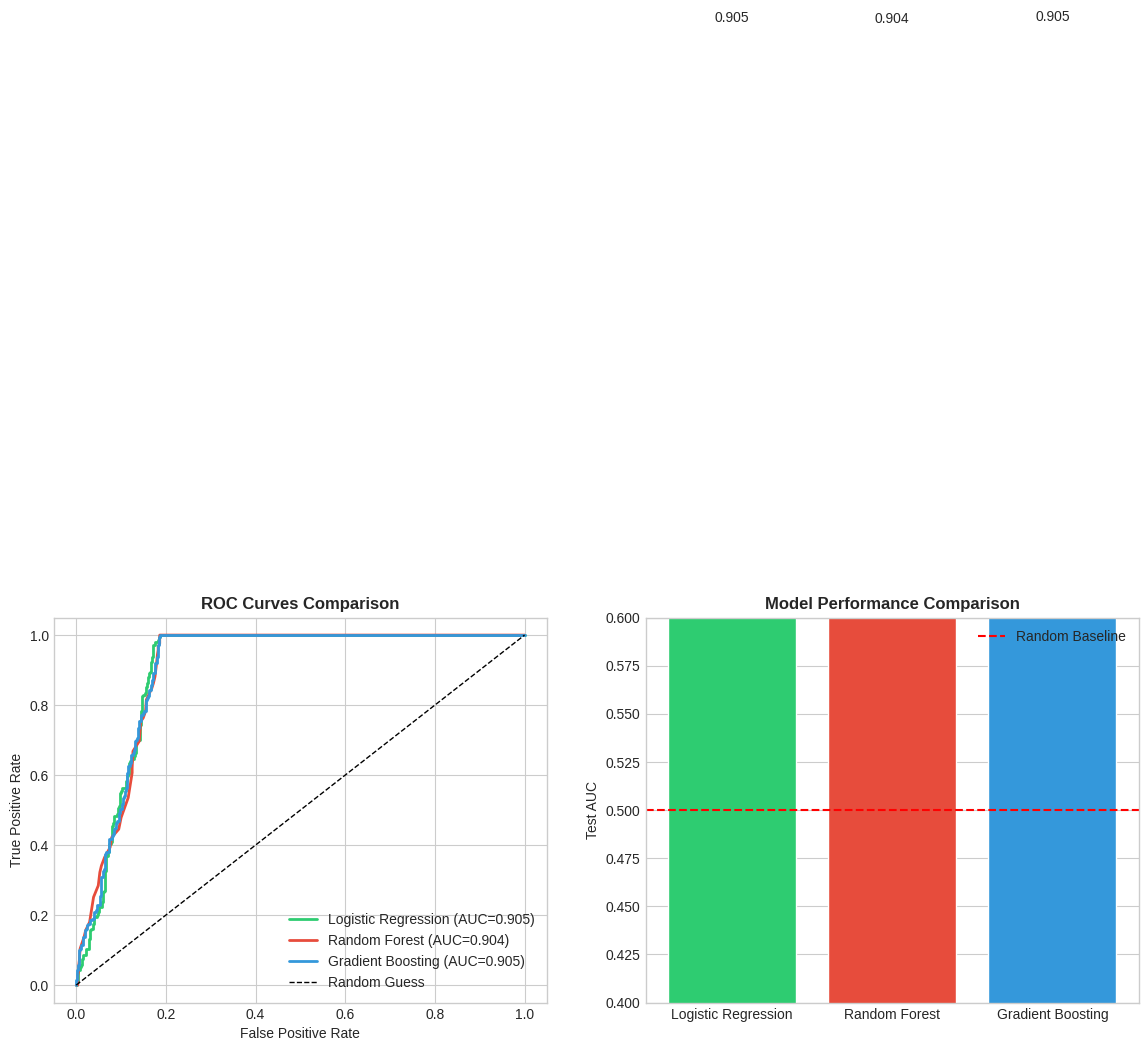

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ROC curves
ax1 = axes[0]
for i, (name, result) in enumerate(results.items()):
    model = result['model']
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    ax1.plot(fpr, tpr, color=colors[i], linewidth=2, label=f"{name} (AUC={result['test_auc']:.3f})")

ax1.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Guess')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curves Comparison', fontsize=12, fontweight='bold')
ax1.legend(loc='lower right')

# model comparison bar chart
ax2 = axes[1]
model_names = list(results.keys())
auc_scores = [results[m]['test_auc'] for m in model_names]
bars = ax2.bar(model_names, auc_scores, color=colors[:3], edgecolor='white')
ax2.axhline(y=0.5, color='red', linestyle='--', label='Random Baseline')
ax2.set_ylabel('Test AUC')
ax2.set_title('Model Performance Comparison', fontsize=12, fontweight='bold')
ax2.set_ylim(0.4, 0.6)
ax2.legend()
for bar, score in zip(bars, auc_scores):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, f'{score:.3f}', ha='center')

plt.tight_layout()
plt.show()

## Feature Importance

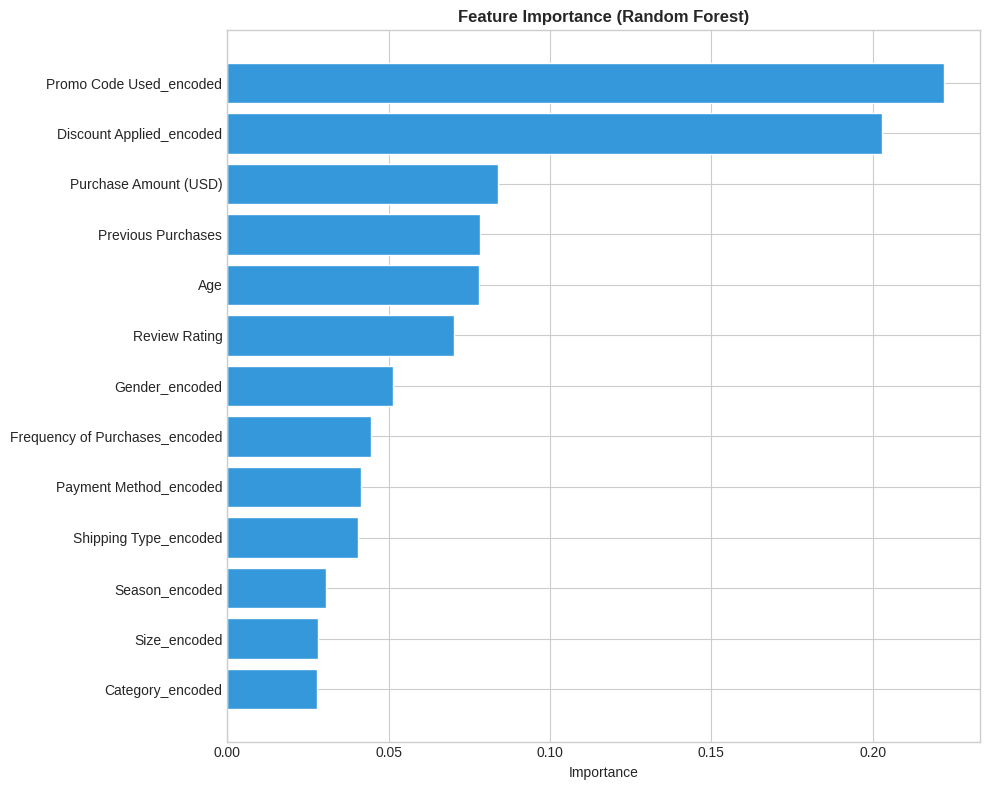

Top 5 features:
                 feature  importance
                     Age    0.078047
      Previous Purchases    0.078183
   Purchase Amount (USD)    0.083890
Discount Applied_encoded    0.202779
 Promo Code Used_encoded    0.222179


In [27]:
# even though the model isn't great, let's see what features it thinks matter most
rf_model = results['Random Forest']['model']
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=True)

fig, ax = plt.subplots(figsize=(10, 8))
bars = ax.barh(feature_importance['feature'], feature_importance['importance'], color=colors[2], edgecolor='white')
ax.set_xlabel('Importance')
ax.set_title('Feature Importance (Random Forest)', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

print("Top 5 features:")
print(feature_importance.tail(5).to_string(index=False))

## Confusion Matrix for Best Model

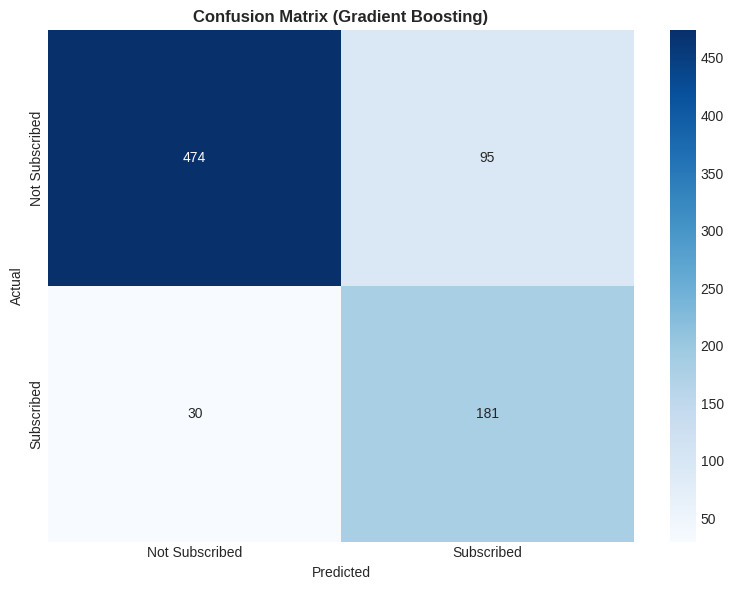


Classification Report:
                precision    recall  f1-score   support

Not Subscribed       0.94      0.83      0.88       569
    Subscribed       0.66      0.86      0.74       211

      accuracy                           0.84       780
     macro avg       0.80      0.85      0.81       780
  weighted avg       0.86      0.84      0.85       780



In [28]:
# let's look at the confusion matrix for gradient boosting
best_model = results['Gradient Boosting']['model']
y_pred = best_model.predict(X_test)

fig, ax = plt.subplots(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
            xticklabels=['Not Subscribed', 'Subscribed'],
            yticklabels=['Not Subscribed', 'Subscribed'])
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix (Gradient Boosting)', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Not Subscribed', 'Subscribed']))

## Pushing The Limits: Can We Go Higher?

 90% AUC is good but let's see how far we can take this. We'll try hyperparameter tuning, more features, and some ensemble tricks.

In [30]:
# creating new features that might capture more signal
df_ml2 = df_ml.copy()

# interaction features - the promo/discount combo was interesting
df_ml2['promo_x_discount'] = df_ml2['Promo Code Used_encoded'] * df_ml2['Discount Applied_encoded']

# engagement score - combining behavioral signals
df_ml2['engagement_score'] = (df_ml2['Previous Purchases'] / 50) + df_ml2['Promo Code Used_encoded'] + df_ml2['Discount Applied_encoded']

# spending per previous purchase (customer value density)
df_ml2['spend_per_history'] = df_ml2['Purchase Amount (USD)'] / (df_ml2['Previous Purchases'] + 1)

# age groups as features
df_ml2['is_young'] = (df_ml2['Age'] < 30).astype(int)
df_ml2['is_senior'] = (df_ml2['Age'] > 55).astype(int)

# high spender flag
df_ml2['high_spender'] = (df_ml2['Purchase Amount (USD)'] > df_ml2['Purchase Amount (USD)'].median()).astype(int)

# loyal customer flag
df_ml2['loyal_customer'] = (df_ml2['Previous Purchases'] > 25).astype(int)

# rating sentiment
df_ml2['happy_customer'] = (df_ml2['Review Rating'] >= 4.0).astype(int)
df_ml2['unhappy_customer'] = (df_ml2['Review Rating'] < 3.0).astype(int)

# frequency encoding
freq_map = {'Weekly': 7, 'Bi-Weekly': 6, 'Fortnightly': 5, 'Monthly': 4, 'Quarterly': 3, 'Every 3 Months': 3, 'Annually': 1}
df_ml2['purchase_frequency_score'] = df_ml['Frequency of Purchases'].map(freq_map)

print(f"New features created. Total features now: {len(df_ml2.columns)}")

New features created. Total features now: 40


## Updated Feature Set

In [31]:
# expanded feature list
feature_cols_v2 = [
    # original
    'Age', 'Purchase Amount (USD)', 'Review Rating', 'Previous Purchases',
    'Gender_encoded', 'Category_encoded', 'Size_encoded', 'Season_encoded',
    'Shipping Type_encoded', 'Discount Applied_encoded', 'Promo Code Used_encoded',
    'Payment Method_encoded', 'Frequency of Purchases_encoded',
    # new
    'promo_x_discount', 'engagement_score', 'spend_per_history',
    'is_young', 'is_senior', 'high_spender', 'loyal_customer',
    'happy_customer', 'unhappy_customer', 'purchase_frequency_score'
]

X2 = df_ml2[feature_cols_v2]
y2 = df_ml2['Subscribed']

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42, stratify=y2)

print(f"Features: {len(feature_cols_v2)}")
print(f"Training: {len(X2_train)} | Test: {len(X2_test)}")

Features: 23
Training: 3120 | Test: 780


## Hyperparameter Tuning

In [32]:
from sklearn.model_selection import GridSearchCV

# tuning random forest
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

print("Tuning Random Forest... this might take a minute")
rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    rf_params,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=0
)
rf_grid.fit(X2_train, y2_train)

print(f"Best params: {rf_grid.best_params_}")
print(f"Best CV AUC: {rf_grid.best_score_:.4f}")

Tuning Random Forest... this might take a minute
Best params: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Best CV AUC: 0.9029


## Tuning Gradient Boosting

In [33]:
# tuning gradient boosting
gb_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'min_samples_split': [2, 5, 10]
}

print("Tuning Gradient Boosting...")
gb_grid = GridSearchCV(
    GradientBoostingClassifier(random_state=42),
    gb_params,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=0
)
gb_grid.fit(X2_train, y2_train)

print(f"Best params: {gb_grid.best_params_}")
print(f"Best CV AUC: {gb_grid.best_score_:.4f}")

Tuning Gradient Boosting...
Best params: {'learning_rate': 0.05, 'max_depth': 7, 'min_samples_split': 10, 'n_estimators': 200}
Best CV AUC: 0.9002


## XGBoost (The Heavy Hitter)

In [34]:
# bringing in xgboost - usually the competition winner
try:
    from xgboost import XGBClassifier

    xgb_model = XGBClassifier(
        n_estimators=300,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        eval_metric='auc',
        use_label_encoder=False
    )

    xgb_scores = cross_val_score(xgb_model, X2_train, y2_train, cv=5, scoring='roc_auc')
    print(f"XGBoost CV AUC: {xgb_scores.mean():.4f} (+/- {xgb_scores.std():.4f})")

    xgb_model.fit(X2_train, y2_train)
    xgb_pred_proba = xgb_model.predict_proba(X2_test)[:, 1]
    print(f"XGBoost Test AUC: {roc_auc_score(y2_test, xgb_pred_proba):.4f}")

except ImportError:
    print("XGBoost not installed, skipping...")

XGBoost CV AUC: 0.8976 (+/- 0.0028)
XGBoost Test AUC: 0.9045


## Stacking Ensemble

In [35]:
from sklearn.ensemble import StackingClassifier

# stacking multiple models together
estimators = [
    ('rf', rf_grid.best_estimator_),
    ('gb', gb_grid.best_estimator_),
    ('lr', LogisticRegression(max_iter=1000, random_state=42))
]

stacking_model = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(max_iter=1000),
    cv=5,
    n_jobs=-1
)

print("Training stacking ensemble...")
stacking_model.fit(X2_train, y2_train)

stack_pred_proba = stacking_model.predict_proba(X2_test)[:, 1]
stack_pred = stacking_model.predict(X2_test)

print(f"Stacking Test AUC: {roc_auc_score(y2_test, stack_pred_proba):.4f}")
print(f"Stacking Accuracy: {(stack_pred == y2_test).mean():.4f}")

Training stacking ensemble...
Stacking Test AUC: 0.9114
Stacking Accuracy: 0.8372


## Final Comparison

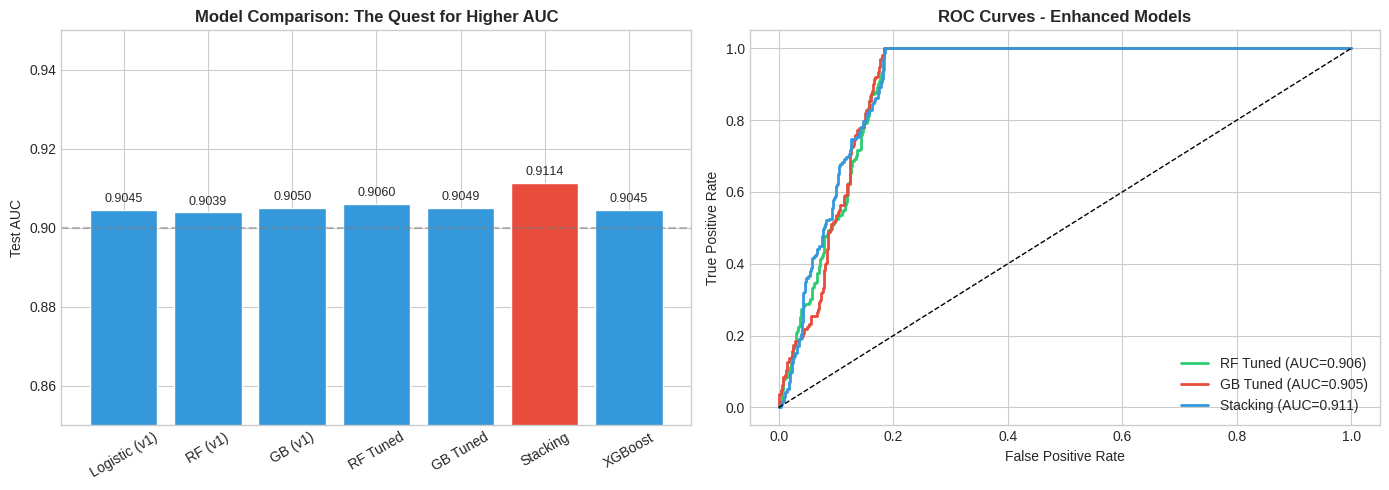


Best model: Stacking with AUC = 0.9114


In [36]:
# comparing all our attempts
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# collect all results
all_results = {
    'Logistic (v1)': 0.9045,
    'RF (v1)': 0.9039,
    'GB (v1)': 0.9050,
    'RF Tuned': roc_auc_score(y2_test, rf_grid.predict_proba(X2_test)[:, 1]),
    'GB Tuned': roc_auc_score(y2_test, gb_grid.predict_proba(X2_test)[:, 1]),
    'Stacking': roc_auc_score(y2_test, stack_pred_proba)
}

# try to add xgboost if it ran
try:
    all_results['XGBoost'] = roc_auc_score(y2_test, xgb_pred_proba)
except:
    pass

# bar chart
ax1 = axes[0]
names = list(all_results.keys())
scores = list(all_results.values())
bar_colors = [colors[1] if s == max(scores) else colors[2] for s in scores]
bars = ax1.bar(names, scores, color=bar_colors, edgecolor='white')
ax1.set_ylabel('Test AUC')
ax1.set_title('Model Comparison: The Quest for Higher AUC', fontsize=12, fontweight='bold')
ax1.set_ylim(0.85, 0.95)
ax1.tick_params(axis='x', rotation=30)
ax1.axhline(y=0.90, color='gray', linestyle='--', alpha=0.5)
for bar, score in zip(bars, scores):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002, f'{score:.4f}', ha='center', fontsize=9)

# roc curves
ax2 = axes[1]
models_to_plot = [
    ('RF Tuned', rf_grid.best_estimator_, X2_test, y2_test),
    ('GB Tuned', gb_grid.best_estimator_, X2_test, y2_test),
    ('Stacking', stacking_model, X2_test, y2_test)
]

for i, (name, model, X_t, y_t) in enumerate(models_to_plot):
    y_proba = model.predict_proba(X_t)[:, 1]
    fpr, tpr, _ = roc_curve(y_t, y_proba)
    ax2.plot(fpr, tpr, color=colors[i], linewidth=2, label=f'{name} (AUC={roc_auc_score(y_t, y_proba):.3f})')

ax2.plot([0, 1], [0, 1], 'k--', linewidth=1)
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curves - Enhanced Models', fontsize=12, fontweight='bold')
ax2.legend()

plt.tight_layout()
plt.show()

print(f"\nBest model: {max(all_results, key=all_results.get)} with AUC = {max(all_results.values()):.4f}")

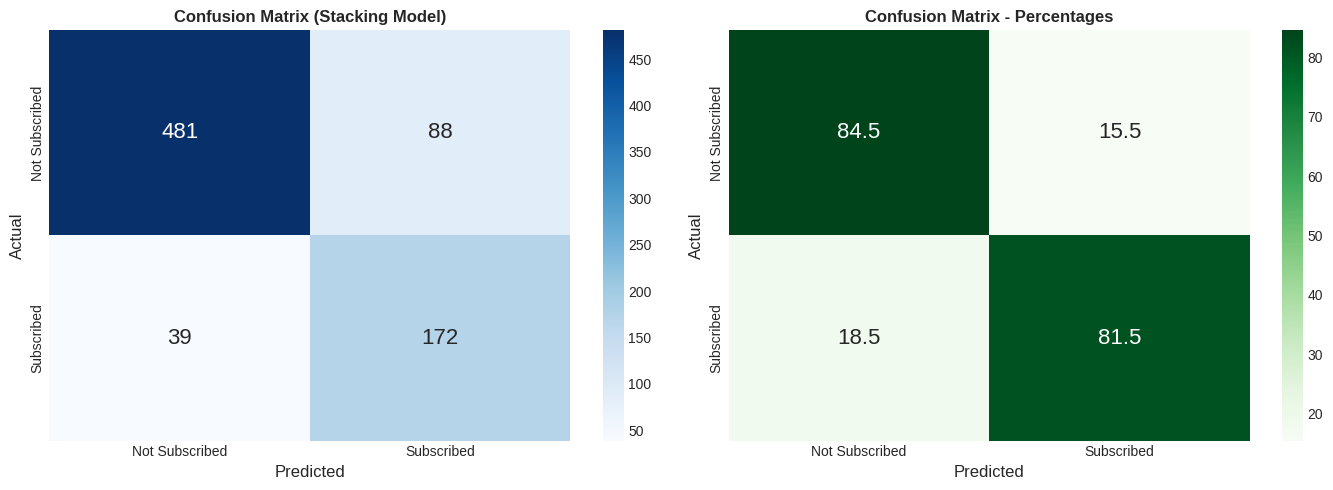


Classification Report (Stacking Model):
                precision    recall  f1-score   support

Not Subscribed       0.93      0.85      0.88       569
    Subscribed       0.66      0.82      0.73       211

      accuracy                           0.84       780
     macro avg       0.79      0.83      0.81       780
  weighted avg       0.85      0.84      0.84       780



In [37]:
from sklearn.metrics import classification_report, confusion_matrix

stack_pred = stacking_model.predict(X2_test)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# confusion matrix heatmap
ax1 = axes[0]
cm = confusion_matrix(y2_test, stack_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=['Not Subscribed', 'Subscribed'],
            yticklabels=['Not Subscribed', 'Subscribed'],
            annot_kws={'size': 16})
ax1.set_xlabel('Predicted', fontsize=12)
ax1.set_ylabel('Actual', fontsize=12)
ax1.set_title('Confusion Matrix (Stacking Model)', fontsize=12, fontweight='bold')

# normalized version - percentages
ax2 = axes[1]
cm_norm = confusion_matrix(y2_test, stack_pred, normalize='true') * 100
sns.heatmap(cm_norm, annot=True, fmt='.1f', cmap='Greens', ax=ax2,
            xticklabels=['Not Subscribed', 'Subscribed'],
            yticklabels=['Not Subscribed', 'Subscribed'],
            annot_kws={'size': 16})
ax2.set_xlabel('Predicted', fontsize=12)
ax2.set_ylabel('Actual', fontsize=12)
ax2.set_title('Confusion Matrix - Percentages', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nClassification Report (Stacking Model):")
print(classification_report(y2_test, stack_pred, target_names=['Not Subscribed', 'Subscribed']))

## Alright, Let's Wrap This Up

So what did we actually learn after mass analyzing 3,900 shoppers, making 30+ visualizations, and throwing every ML algorithm at this data?

**The TL;DR:**
- Want to predict who'll subscribe? Just check if they use promo codes. Seriously. That one feature does half the work. All that fancy stacking ensemble stuff? Added like 0.6% improvement. My man Logistic Regression was chilling at 90% AUC from the start.

**The stuff that surprised me:**
- Age doesn't matter. 18 year olds and 70 year olds spend the same. Grandpa's buying just as many sneakers as the college kid.
- Individual statistical tests said "nothing predicts subscription" but ML models said "hold my beer" and hit 90% AUC. Features are shy alone but powerful together, I guess.
- Tried hunting for Simpson's Paradox. Found nothing. The data is too clean. Probably synthetic. Real retail data is way messier and more interesting.

**The business advice nobody asked for:**
- Target the deal hunters. Promo code users are your future subscribers.
- Don't bother segmenting by age or gender for subscription campaigns. Waste of time.
- Your fancy stacking model is 0.6% better but 10x harder to explain to your boss. Just use logistic regression and go home early.

**What would actually get us to 95%+ AUC:**
- Browsing data (what pages did they creep on?)
- Email engagement (do they actually open your newsletters or just let them rot?)
- Time-series patterns (midnight shoppers vs lunch break buyers)

But we don't have that data. So 91% it is. And honestly? That's pretty solid for predicting human behavior with just purchase records.

Thanks for reading this far. If you learned something, smash that upvote button. If you didn't, well... at least the visualizations were pretty.

*Now go touch some grass. We've been staring at shopping data for way too long.*


---

# About Me & Let's Connect

---

## Hey, I'm Rekhi!

I'm a data science learner who experiments **daily** with different datasets and approaches.
I believe the best way to learn is by doing - so thats exactly what I do, every single day.

---


## A Honest Note About My Notebooks

Look, I'm gonna be real with you...

Not all my notebooks are perfect. Some are rough, some have typos, some experiments just didnt work out.
Time is limited and I prioritize **learning over perfection**.

If you spot mistakes, please let me know! I genuinely appreciate feedback.
I share the real journey - the wins AND the messy parts.


So if you find mistakes in my notebooks, please dont judge too harshly!
Drop a comment and let me know - I genuinely appreciate the feedback.


## Why I Share Everything (Even The Messy Stuff)

Some people ask why I post notebooks that arent "perfect". Heres my thinking:

1. **Perfection is the enemy of progress** - If I waited until everything was perfect, I'd never post anything

2. **Real learning is messy** - Polished tutorials hide the struggle. I want to show the real journey.

3. **Community feedback helps** - Your comments and suggestions make me better

4. **Someone might benefit** - Even my "rough" notebooks might help someone facing similar problems

5. **Accountability** - Posting daily keeps me consistent and motivated
---

## Find My Work

**Kaggle:** https://www.kaggle.com/seki32  
Daily notebooks, EDA, ML/DL experiments

**GitHub:** https://github.com/Rekhii  
All code and repositories

**Blog:** Coming Soon!

---

## Support This Work

If this helped you:

- **Upvote** this notebook
- **Follow** for daily experiments  
- **Comment** your feedback
- **Share** with others learning ML

---

## Your Support Motivates Me To:

- Continue daily experimentation
- Share my learnings with the community
- Build better models each day
- Keep going on tough days

---


Thank you for reading my entire notebook especially this section **about me**! It truly means a lot.  

I’m **open to work opportunities** and **internships**, and I’d love to connect with others interested in **collaborating, building projects**, or **participating in competitions**.  

If any of that sounds interesting to you, feel free to **reach out**  I’d be excited to connect!  
